Name : Arash Asgari

St Num: 400201037

Paper Subject Classification and Clustering

Link to Document: https://docs.google.com/document/d/1Zu0MznRUBjMRtcF63IZflAbNlBoNqPBSYd4UcqgCrUQ/edit?usp=sharing

In [28]:
!pip install pymed

In [78]:
from pymed import PubMed
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string

In [74]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

First we download 5000 abstracts of papers on 5 different subjects.

Filter Papers with an abstranct length of more than 1000

At last we keep 500 paper of each subject for training and 150 papers for testing.

In [53]:
from types import LambdaType
from pymed import PubMed
pubmed = PubMed(tool="MyTool", email="my@email.address")
covid_papers = list(pubmed.query("covid-19", max_results=1000))
breast_papers = list(pubmed.query("breast cancer", max_results=1000))
heart_papers = list(pubmed.query("heart rate", max_results=1000))
eeg_papers = list(pubmed.query("eeg", max_results=1000))
obesity_papers = list(pubmed.query("obesity", max_results=1000))

In [63]:
def filter_paper(papers):
  for paper in papers:
    if (paper.abstract is None) or (len(paper.abstract) < 1000):
      papers.remove(paper)
  return papers

In [124]:
covid_papers = filter_paper(covid_papers)
print("number of covid papers after filtering: ", len(covid_papers))
breast_papers = filter_paper(breast_papers)
print("number of breast cancer papers after filtering: ", len(breast_papers))
heart_papers = filter_paper(heart_papers)
print("number of heart rate papers after filtering: ", len(heart_papers))
eeg_papers = filter_paper(eeg_papers)
print("number of eeg papers after filtering: ", len(eeg_papers))
obesity_papers = filter_paper(obesity_papers)
print("number of obesity papers after filtering: ", len(obesity_papers))


number of covid papers after filtering:  652
number of breast cancer papers after filtering:  679
number of heart rate papers after filtering:  805
number of eeg papers after filtering:  796
number of obesity papers after filtering:  709


In [130]:
train_papers = [covid_papers[:500], breast_papers[:500], heart_papers[:500], eeg_papers[:500], obesity_papers[:500]]
test_papers = [covid_papers[500:650], breast_papers[500:650], heart_papers[500:650], eeg_papers[500:650], obesity_papers[500:650]]

# Paper subject classification using word freq

In [129]:
def normalize_abstract(abstract : str):
  sentences = sent_tokenize(abstract)
  sentences = [word_tokenize(sentence) for sentence in sentences]
  
  sentences = normalize_sentence(sentences, lower_case=True)
  return sentences


In [89]:
def normalize_sentence(tokenized_sents, minimum_length=2, stopword_removal=True, stopwords_domain=[], lower_case=False, punctuation_removal=True):
    '''
    normalization function
    '''
    normalized_sents = tokenized_sents
    
    if stopword_removal:
        # Remove stopwords in English and also the given domain stopwords
        stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
        normalized_sents=[[word for word in sentence if (word.lower() not in stopwords_domain + stopwords)] for sentence in tokenized_sents ]

    if punctuation_removal:
        # Remove punctuations
        normalized_sents=[[word for word in sentence if word not in string.punctuation] for sentence in normalized_sents ]

    if lower_case:
        # Convert everything to lowercase and filter based on a min length
        normalized_sents=[[word.lower() for word in sentence if len(word)>minimum_length] for sentence in normalized_sents ]

    elif minimum_length>1:
        normalized_sents= [[word for word in sentence if len(word)>minimum_length] for sentence in normalized_sents ]        
        
    return normalized_sents

In [135]:
def create_total_doc(papers):
  index = 0
  merged_abstracts = []
  for paper in papers:
    index = index + 1
    normalized_abstract = normalize_abstract(paper.abstract)
    merged_abstracts = merged_abstracts + normalized_abstract
  return merged_abstracts

In [138]:
total_docs = [create_total_doc(train_paper) for train_paper in train_papers]

In [139]:
from nltk.probability import FreqDist
import numpy as np
import itertools

def frequent_word_finder(total_doc, words_num = 20, keep_count = False):
  mp_freqdist = FreqDist(itertools.chain(*total_doc))               # compute the frequency distribution
  top_words=mp_freqdist.most_common(words_num)      # show the top (word, frequency) pairs
  if keep_count:
    return top_words
  else:
    return [word[0] for word in top_words]

In [140]:
top_words_list = [frequent_word_finder(total_doc) for total_doc in total_docs]

In [155]:
def predict_paper(paper, top_words_list):
  count_list = [0, 0, 0, 0, 0]
  normalized_abstract = normalize_abstract(paper.abstract)
  for sent in normalized_abstract:
    for word in sent:
      for ind, top_words in enumerate(top_words_list):
        if word in top_words:
          count_list[ind] = count_list[ind] + 1
  return count_list

In [160]:
def predict_test_papers(test_papers_list, top_words_list):
  results = []
  for paper in test_papers_list:
    res = predict_paper(paper, top_words_list)
    results.append(res)
  return results

In [162]:
results = []
for test_papers_list in test_papers :
  res = predict_test_papers(test_papers_list, top_words_list)
  results = results + res
print(results)

[[10, 1, 5, 1, 10], [17, 6, 6, 4, 7], [2, 0, 0, 0, 0], [14, 5, 4, 3, 3], [9, 4, 3, 5, 3], [10, 8, 6, 8, 2], [10, 5, 11, 7, 8], [29, 3, 2, 2, 7], [23, 14, 13, 10, 8], [19, 3, 11, 4, 22], [6, 4, 2, 5, 0], [20, 17, 18, 11, 13], [10, 7, 14, 7, 10], [3, 2, 1, 0, 2], [5, 10, 8, 4, 3], [6, 7, 5, 6, 4], [25, 26, 26, 19, 18], [4, 0, 0, 1, 2], [15, 12, 11, 8, 12], [14, 11, 10, 3, 9], [8, 2, 2, 2, 1], [6, 3, 2, 3, 1], [8, 2, 2, 3, 2], [6, 5, 11, 5, 9], [24, 14, 14, 13, 12], [8, 3, 3, 2, 6], [21, 5, 5, 14, 2], [14, 11, 11, 11, 13], [15, 4, 2, 1, 4], [16, 1, 3, 2, 6], [14, 14, 16, 10, 18], [19, 2, 3, 4, 5], [5, 1, 0, 1, 2], [11, 4, 3, 3, 4], [6, 6, 4, 10, 6], [18, 11, 34, 9, 28], [25, 10, 16, 5, 20], [4, 3, 3, 3, 3], [5, 0, 1, 1, 1], [29, 6, 7, 6, 5], [5, 5, 4, 2, 3], [16, 8, 8, 6, 6], [12, 5, 8, 4, 9], [19, 8, 8, 8, 10], [23, 18, 23, 18, 8], [4, 3, 3, 1, 2], [22, 4, 6, 3, 5], [7, 5, 5, 3, 4], [25, 7, 15, 11, 12], [18, 10, 12, 10, 18], [4, 3, 8, 6, 2], [15, 8, 7, 4, 7], [17, 12, 10, 6, 7], [1, 0, 0

In [171]:
predictions = np.argmax(np.array(results), axis = 1)
labels = np.repeat(np.array([0, 1, 2, 3, 4]), 150)

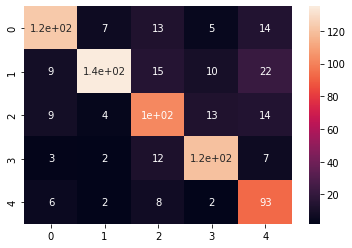

In [176]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(predictions, labels)
ax = sns.heatmap(cm, annot = True)

In [178]:
print("our accuracy using this procedure:")
print(accuracy_score(labels, predictions))

our accuracy using this procedure:
0.764


In [179]:
!pip install git+https://github.com/LIAAD/yake

  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-uk8poqpt
  Running command git clone -q https://github.com/LIAAD/yake /tmp/pip-req-build-uk8poqpt
     |████████████████████████████████| 132 kB 6.4 MB/s 
  Created wheel for yake: filename=yake-0.4.8-py2.py3-none-any.whl size=62565 sha256=0de19bec15dca2d3549984e64899376d9843ff94829bda83f03a44b2b8c8ea8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bizp6_4q/wheels/52/79/f4/dae9309f60266aa3767a4381405002b6f2955fbcf038d804da
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73980 sha256=2ae7881d5e990221be0c51ba1d22bdf87236398073d58e4b96f11a88387bf988
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built yake jellyfish
